In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import sys

sys.path.append('/mnt/sdceph/users/nroy/radmc3d-2.0/python/radmc3dPy')
sys.path.append('/mnt/home/nroy/test/chimes-IGNIS/chimes-driver/ext-lib/pfh_python')

#from simpleplot import *
#from radmc3dPy import image
#from gizmopy.load_from_snapshot import load_from_snapshot
#from gizmopy.load_fire_snap import load_fire_snap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
import matplotlib.patheffects as path_effects
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import Rectangle
import h5py as h5
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.facecolor']='w'


params = {"text.color" : 'w',
          "ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
'''
params = {"text.color" : 'k',
          "ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}

'''
plt.rcParams.update(params)

'''
for generalization, see "#change" throughout code on lines where needs change depending on emission line instance (ctrl+f tofind and change quickly), most changes should be covered by changing the parent variable below.
''';
#parent = '/home/jovyan/radmc3d_data/subtract_com_velocity/A4_33000_snum155/CII_158mu/' #change 

In [2]:
'''KEYS'''

half_mass = 0 #0 for fullmass map, 1 for halfmass map
exclude_low_intensity = 1 #0 for fullmass map, 1 for low intensity exclusion
tolerance = 1 #increase/decrease depending on wanted tolerance
emission = "NII_6585A" #line wanted for maps 
text = r"$\mathbf{[NII]_{6585A}}$"

In [3]:
''' READ IN OF DATA '''
parent = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/60kpc/rotations/48deg/NII_6585A/"
#parent_2 = "/home/jovyan/radmc3d_data/subtract_com_velocity/m12i/60kpc/rotations/0deg/Halpha/HII/" #for Halpha ONLY

In [5]:
filepath_tot = parent + 'image_tot.hdf5'
filepath_con = parent + 'image_continuum.hdf5'
file_con = h5.File(filepath_con,'r')
file_tot = h5.File(filepath_tot,'r')

npix_x = np.shape(file_tot['image_array'][:])[0]
npix_y = np.shape(file_tot['image_array'][:])[1]

image_array = file_tot['image_array'][:] - file_con['image_array'][:]

image_array[image_array < 0] = 0

frequency_array = 3e8 / (file_tot['lambda_array'][:] * 1e-6)

'''
# add here for HI and HII (not an average!) for Halpha
filepath_tot_2 = parent_2 + 'image_tot.hdf5'
filepath_con_2 = parent_2 + 'image_continuum.hdf5'
file_con_2 = h5.File(filepath_con,'r')
file_tot_2 = h5.File(filepath_tot,'r')

npix_x_2 = np.shape(file_tot_2['image_array'][:])[0]
npix_y_2 = np.shape(file_tot_2['image_array'][:])[1]

image_array_2 = file_tot_2['image_array'][:] - file_con_2['image_array'][:]

image_array_2[image_array_2 < 0] = 0

frequency_array_2 = 3e8 / (file_tot_2['lambda_array'][:] * 1e-6)

image_array = image_array + image_array_2
'''

;

''

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


''

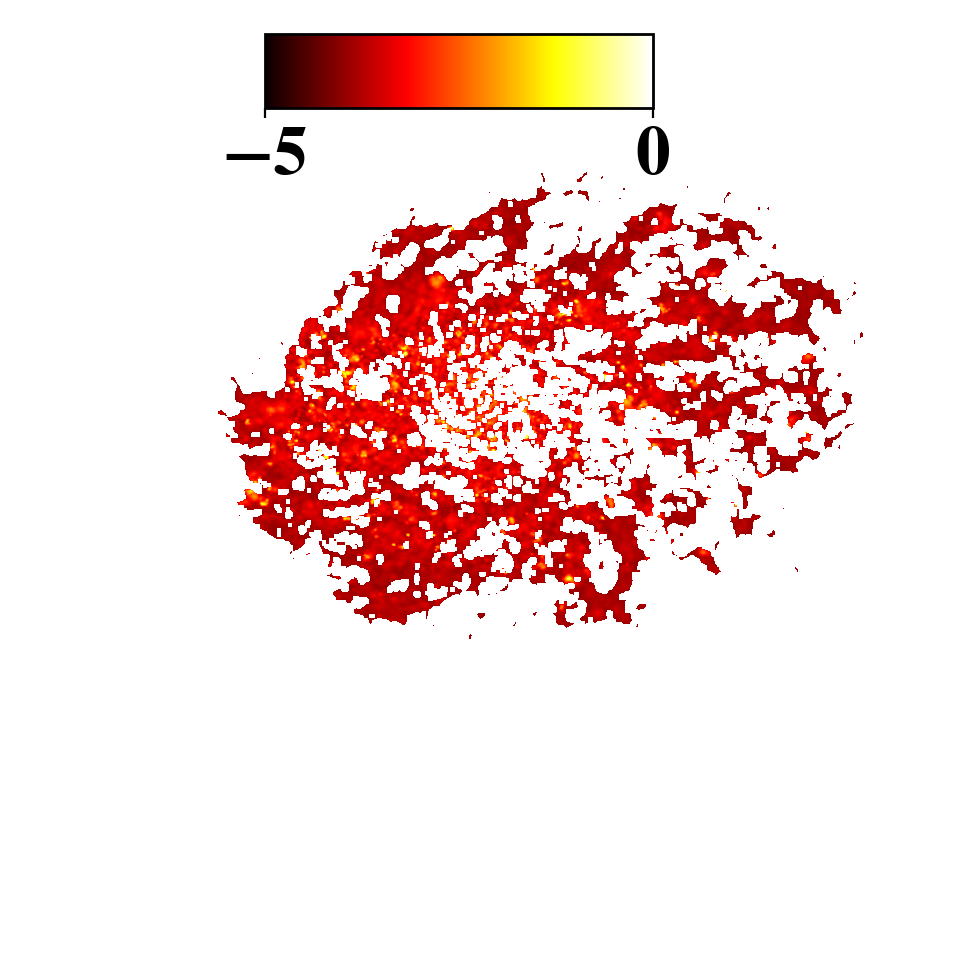

In [7]:
''' CREATING MOMENT 0 '''

#moment 0
integrated_image_array_moment0 = np.zeros((npix_x, npix_y))
delta_nu = np.abs(frequency_array[1:] - frequency_array[:-1])
for i in range(npix_x):
    for j in range(npix_y):
        integrated_image_array_moment0[i, j] = np.sum(delta_nu * (image_array[i, j, :-1] + image_array[i, j, 1:]) / 2.0)

integrated_image_array_moment0[0,0] = 0 #final moment 0 array
M0_arr = integrated_image_array_moment0

if half_mass == 1: 
    r = 256 * (2*2.83/10) #m12i
    #r = 256 * (2*0.82/4) #A4-151
    #r = 256 * (2*0.86/4) #A4-152
    #r = 256 * (2*0.645/4) #A4-155
    midpointx = len(M0_arr) / 2
    midpointy = len(M0_arr[0]) / 2
    for i in range(len(M0_arr)):
        for j in range(len(M0_arr[i])):
            x = i - midpointx
            y = j - midpointy
            dist = np.sqrt(x**2 + y**2)
            if dist > (r + tolerance):
                M0_arr[i][j] = 0
                
if exclude_low_intensity == 1: 
    for i in range(len(M0_arr)):
        for j in range(len(M0_arr[i])):
            if np.log10(M0_arr[i][j]/np.max(M0_arr)) < -4:
                M0_arr[i][j] = 0
        
params = {"text.color" : 'k',
          "ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams.update(params)

figx, figy = 8,6

fig, ax = plt.subplots(figsize=(figx,figy), dpi=200, facecolor='w') #change dpi to 500 for production runs
cmap = matplotlib.cm.hot.copy()
low = cmap(0)
cmap.set_bad(color = low)

#plt.imshow(integrated_image_array.T/np.max(integrated_image_array.T), extent=(-10,10,-10,10), interpolation='bicubic', cmap='hot', vmax=0.2, origin='lower')
plt.imshow(np.log10(M0_arr.T/np.max(M0_arr.T)), extent=(-2,2,-2,2), \
           interpolation='bicubic', cmap='hot', vmin=-5, vmax = 0, origin='lower')
plt.xlabel('X (kpc)', fontsize = 14)
plt.ylabel('Y (kpc)', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis('off')

#0.0,0.8,0.5,0.2

cb = plt.colorbar() 
cb.remove()
colbar = 'k'
cbaxes = inset_axes(ax, width="70%", height="40%", bbox_to_anchor=(0.1,0.8,0.6,0.2), bbox_transform = ax.transAxes)  #change position
cbar = plt.colorbar(cax=cbaxes, orientation='horizontal')

fontprops1 = fm.FontProperties(size = 25, weight = "bold")



#r'$\mathbf{\log\left(\frac{I_{\nu}}{I_{\nu_{max}}}\right)}$'
#cbar.set_label(label = r'$\mathbf{M_0}$',\
#              size = 40, color = colbar)

cbar.ax.tick_params(labelsize=25)
for label in cbar.ax.get_xticklabels():
    label.set_fontproperties(fontprops1) 

cbaxes.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

cbar.outline.set_color('k')
cbar.outline.set_linewidth(1)

fontprops = fm.FontProperties(size=30, weight = "bold")

x_position = -1.5  
y_position = -0.75 
bar_length = 2 
bar_thickness = 0.03 

# Create the scale bar as a rectangle
#scalebar = Rectangle((x_position, y_position), bar_thickness, bar_length,
#                     linewidth=0, color='w')
#ax.add_patch(scalebar)

# Add a rotated label for the scale bar
#ax.text(x_position + 0.25, y_position + bar_length / 2, '30 kpc',
#        va='center', ha='center', rotation=90, color='w',
#        fontproperties=fontprops)

'''
scalebar = AnchoredSizeBar(ax.transData,
                           0.01,
                           '', 
                           (0.25, 0.25), 
                           pad=0.0,
                           color='white',
                           frameon=False,
                           size_vertical=2, 
                           fontproperties=fontprops)

ax.add_artist(scalebar)


ax.text(0.5, 0.5, '30 kpc',  
        va='center', ha='center',
        rotation=90,
        color='b',
        fontproperties=fontprops,
        transform=ax.transAxes)

'''

#plt.title(r'Vel-Integrated NII line emission image of A4 at -50 Myr'
#          '\n [-1000,1000] '
#         r'kms$^{-1}$', fontsize=12)
#plt.title(r'Velocity-Integrated CII image of MW-like galaxy (Face-on)'
#          '\n [-500,500] '
#          r'kms$^{-1}$ ', fontsize=12, usetex = True)

#         dx = 1
#         yrg = [ -dx, dx ]
#         bar_size = 1 #dx / 2.
#         xleft = -1 #-bar_size/2.
#         #xleft += 0.5*dx
#         #ybar = yrg[0] + 0.06*dx
#         ybar= -1.5
#         colbar = 'white'
'''
plt.plot( [xleft,xleft+bar_size], [ybar,ybar], '-', color=colbar, linewidth=2 )
#plt.plot([0,1],[-2,-2],'-',color=colbar,linewidth=2)
bartxt = r'%d kpc' % np.round(bar_size).astype(int)
plt.text( xleft+0.5*bar_size, ybar+0.01*dx, bartxt, {'color':colbar, 'fontsize':50},
        horizontalalignment='center', verticalalignment='bottom' )
plt.tight_layout()
plt.show()


cbar = plt.colorbar(cax=cbaxes, orientation='horizontal')
cbar.set_label(label = r'$\mathrm{log}(\mathrm{I_{\nu}/I_{\nu_{max}}})$',\
    size = 35, color = colbar, fontweight='bold')
label_text_obj = cbar.ax.xaxis.label
glow_effect = withStroke(linewidth=8, foreground='w')
label_text_obj.set_path_effects([glow_effect])
'''
#plt.savefig('m12i_CO_rot48_mom0.png', facecolor='white',bbox_inches='tight', pad_inches = 0)
#plt.show()
;

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log10


''

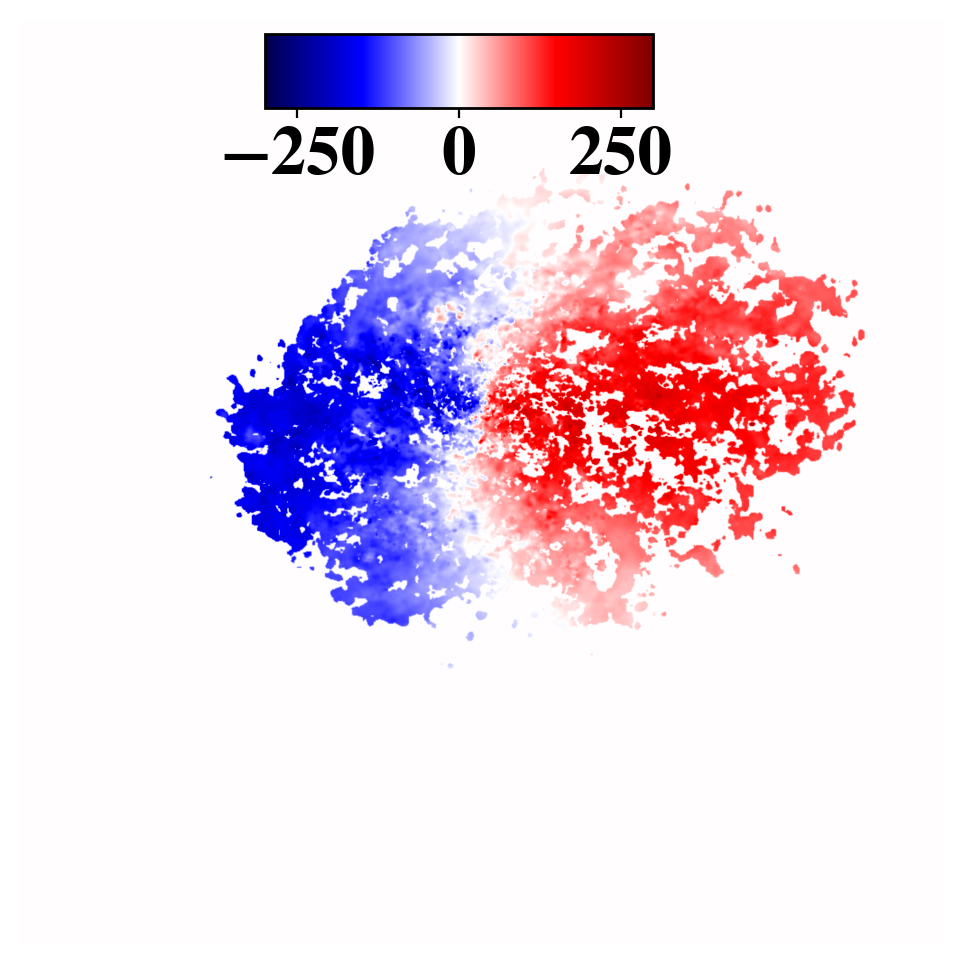

In [8]:
''' CREATING MOMENT 1 '''

#moment 1
#N = np.size(frequency_array)
lambda_0_dict = {"Halpha": 0.65600490570068359, 
                 "Hbeta": 0.48592987656593323, 
                 "CII_158mu": 157.62730407714844, 
                 "CIII_1909A": 0.19074167311191559, 
                 "CIV_1549A": 0.1549701988697052, 
                 "NII_6548A": 0.6545339822769165, 
                 "NII_6585A": 0.65807253122329712, 
                 "NII_122mu": 121.71614837646484, 
                 "NII_205mu": 205.15777587890625, 
                 "NIII_57mu": 57.299877166748047, 
                 "OI_6300A": 0.62976968288421631, 
                 "OI_63mu": 63.141555786132812, 
                 "OI_145mu": 145.43453979492188, 
                 "OIII_5007A": 0.50047838687896729, 
                 "OIII_88mu": 88.295417785644531, 
                 "OIV_25mu": 25.87542724609375, 
                 "NeII_12mu": 12.804655075073242, 
                 "NeIII_15mu": 15.543784141540527, 
                 "NeIII_3869A" : 0.3867171793754335, 
                 "NeV_14mu": 14.316787719726562, 
                 "NeV_24mu": 24.196403503417969, 
                 "NeV_3426A" : 0.34246401541369015, 
                 "NeVI_7mu": 7.6469192504882812, 
                 "SII_6716A": 0.67136573791503906, 
                 "SII_6731A": 0.67280274629592896, 
                 "SIII_18mu": 18.69268798828125, 
                 "SIII_33mu": 33.477680206298828, 
                 "OH_119mu": 119.2344054, 
                 "OH_79mu": 79.11554517, 
                 "CO_J10": 2600.757634, 
                 "CO_J21": 1300.409306, 
                 "CO_J32": 866.9573561, 
                 "H2_S0": 28.20116197, 
                 "H2_S1": 17.02286, 
                 "H2_S2": 12.27005, 
                 "H2_S3": 9.658245, 
                 "H2_S4": 8.020273784487, 
                 "H2_S5": 6.9043643122631, 
                 "H2_S6": 6.1046325092047, 
                 "H2_S7": 5.5076594297122, 
                 "H2_v10_S0": 2.2217649691379, 
                 "H2_v10_S1": 2.1203669030368, 
                 "H2_v10_S2": 2.0323526932214, 
                 "H2_v10_S3": 1.956205356835, 
                 "H2_v21_S0": 2.3540038049302, 
                 "H2_v21_S1": 2.2461702538386, 
                 "H2_v21_S2": 2.1527386045601, 
                 "H2_v21_S3": 2.0720789496223}

lambda_0 = lambda_0_dict[emission]
lambda_array = np.array(file_con['lambda_array'])
velocity_arr = (lambda_array - lambda_0) * 3e5 / lambda_array 


moment1_noint = velocity_arr * image_array

integrated_image_array_moment1 = np.zeros((npix_x, npix_y))

for i in range(npix_x):
    for j in range(npix_y):
        integrated_image_array_moment1[i, j] = np.sum(delta_nu * (moment1_noint[i, j, :-1] + moment1_noint[i, j, 1:]) / 2.0)

#integrated_image_array_moment1[0,0] = 0

isolate_moment_1 = integrated_image_array_moment1 / integrated_image_array_moment0
#isolate_moment_1[0,0] = 0 #final moment 1 array
M1_arr = isolate_moment_1

if half_mass == 1: 
    r = 256 * (2*2.83/10) #m12i
    #r = 256 * (2*0.82/4) #A4-151
    #r = 256 * (2*0.86/4) #A4-152
    #r = 256 * (2*0.645/4) #A4-155
    midpointx = len(M1_arr) / 2
    midpointy = len(M1_arr[0]) / 2
    for i in range(len(M1_arr)):
        for j in range(len(M1_arr[i])): 
            x = i - midpointx
            y = j - midpointy
            dist = np.sqrt(x**2 + y**2)
            if dist > (r + tolerance):
                M1_arr[i][j] = 0
                
if exclude_low_intensity == 1: 
    for i in range(len(M0_arr)):
        for j in range(len(M0_arr[i])):
            if np.log10(M0_arr[i][j]/np.max(M0_arr)) < -4:
                M1_arr[i][j] = 0

p = "k"
        
params = {"text.color" : p,
          "ytick.color" : p,
          "xtick.color" : p,
          "axes.labelcolor" : p,
          "axes.edgecolor" : p}
plt.rcParams.update(params)

figx, figy = 8,6

fig, ax = plt.subplots(figsize=(figx,figy), dpi=200, facecolor='w')
#integrated_image_array[0,0] = 0
cmap = matplotlib.cm.hot.copy()
low = cmap(0)
cmap.set_bad(color = low)

v_minmax = 300

#plt.imshow(integrated_image_array.T/np.max(integrated_image_array.T), extent=(-10,10,-10,10), interpolation='bicubic', cmap='hot', vmax=0.2, origin='lower')
plt.imshow(M1_arr.T, vmin = -v_minmax, vmax = v_minmax, extent=(-2,2,-2,2), \
           interpolation='bicubic', cmap='seismic', origin='lower')
plt.xlabel('X (kpc)', fontsize = 14)
plt.ylabel('Y (kpc)', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis('off')
#plt.colorbar(label=r'$I_{\nu}$ / max($I_{\nu}$)')

cb = plt.colorbar() 
cb.remove()
colbar = p
cbaxes = inset_axes(ax, width="70%", height="40%", bbox_to_anchor=(0.1,0.8,0.6,0.2), bbox_transform = ax.transAxes)  #change position
cbar = plt.colorbar(cax=cbaxes, orientation='horizontal')

#r'$\mathbf{\frac{\Sigma_{n=1}^{npix}(I_{\nu n} v_n)}{M_0}}$'
#cbar.set_label(label = r'$\mathbf{M_1}$',\
#               size = 40, color = colbar)

cbar.ax.tick_params(labelsize=25)
for label in cbar.ax.get_xticklabels():
    label.set_fontproperties(fontprops1) 


cbar.outline.set_color(p)
cbar.outline.set_linewidth(1)
cbar.ax.xaxis.set_tick_params(color=p)




#cbar.set_ticks([-4, -2, 0])
#cbar.set_ticklabels([-4,-2,0],size = 35, color = colbar)

#plt.text(0.1,0.9, line, fontsize = 35) #change

#plt.title(r'Vel-Integrated NII line emission image of A4 at -50 Myr'
#          '\n [-1000,1000] '
#         r'kms$^{-1}$', fontsize=12)
#plt.title(r'Velocity-Integrated CII image of MW-like galaxy (Face-on)'
#          '\n [-500,500] '
#          r'kms$^{-1}$ ', fontsize=12, usetex = True)



'''
dx = 1
yrg = [ -dx, dx ]
bar_size = 1 #dx / 2.
xleft = -1 #-bar_size/2.
#xleft += 0.5*dx
#ybar = yrg[0] + 0.06*dx
ybar= -1.5
colbar = 'white'

plt.plot( [xleft,xleft+bar_size], [ybar,ybar], '-', color=colbar, linewidth=2 )
#plt.plot([0,1],[-2,-2],'-',color=colbar,linewidth=2)
bartxt = r'%d kpc' % np.round(bar_size).astype(int)
plt.text( xleft+0.5*bar_size, ybar+0.01*dx, bartxt, {'color':colbar, 'fontsize':50},
        horizontalalignment='center', verticalalignment='bottom' )
plt.tight_layout()
plt.show()
'''
#plt.savefig('m12i_CO_rot48_mom1.png', facecolor='white',bbox_inches='tight', pad_inches = 0)
#plt.show()
;

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10


''

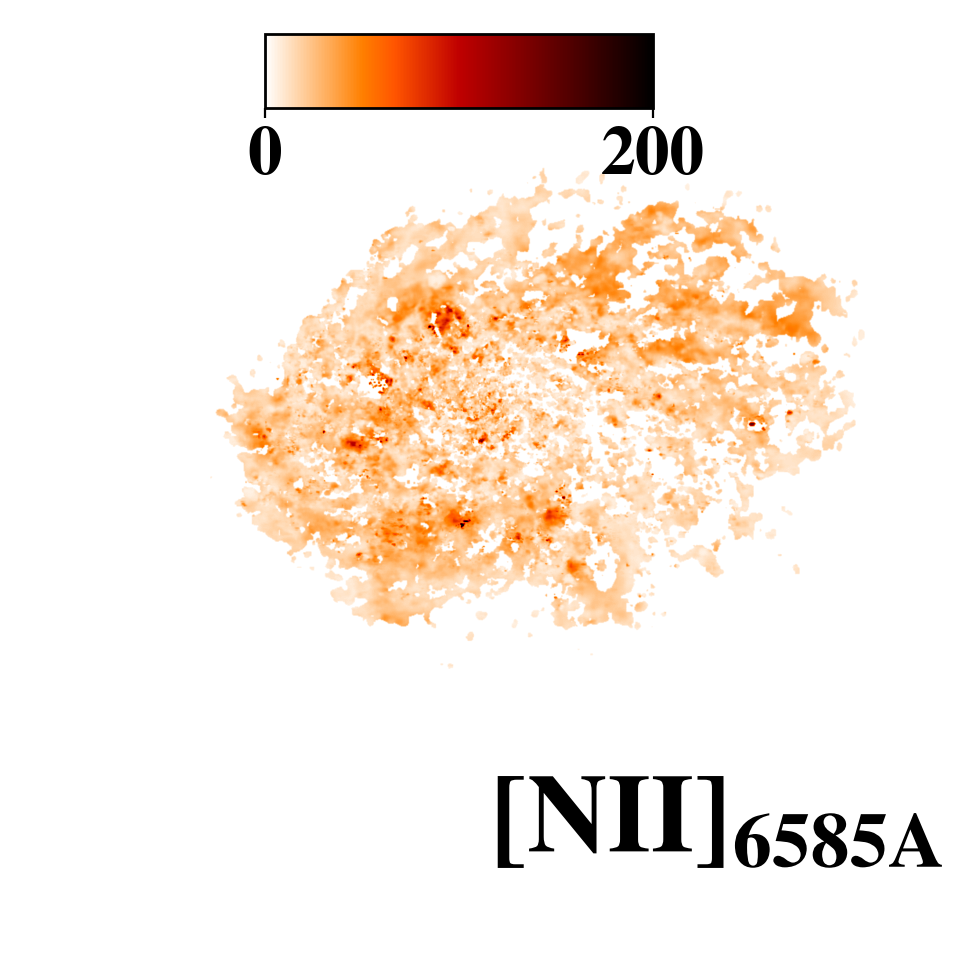

In [10]:
# ''' CREATING MOMENT 2 '''

#moment 2
isolate_moment_1_3D = np.empty([len(image_array), len(image_array), len(velocity_arr)])

for i in range(len(velocity_arr)):
    for j in range(len(image_array)):
        for k in range(len(image_array)):
            isolate_moment_1_3D[j][k][i] = isolate_moment_1[j][k]

moment2_noint = image_array * ((velocity_arr - isolate_moment_1_3D) * (velocity_arr - isolate_moment_1_3D))

integrated_image_array_moment2 = np.zeros((npix_x, npix_y))

for i in range(npix_x):
    for j in range(npix_y):
        integrated_image_array_moment2[i, j] = np.sum(delta_nu * (moment2_noint[i, j, :-1] + moment2_noint[i, j, 1:]) / 2.0)

integrated_image_array_moment2[0,0] = 0

isolate_moment_2 = integrated_image_array_moment2 / integrated_image_array_moment0
isolate_moment_2[0,0] = 0

isolate_moment_2 = np.sqrt(isolate_moment_2) #final moment 2 array
M2_arr = isolate_moment_2

if half_mass == 1: 
    r = 256 * (2*2.83/10) #m12i
    #r = 256 * (2*0.82/4) #A4-151
    midpointx = len(M2_arr) / 2
    midpointy = len(M2_arr[0]) / 2
    for i in range(len(M2_arr)):
        for j in range(len(M2_arr[i])): 
            x = i - midpointx
            y = j - midpointy
            dist = np.sqrt(x**2 + y**2)
            if dist > (r + tolerance):
                M2_arr[i][j] = 0
                
if exclude_low_intensity == 1: 
    for i in range(len(M0_arr)):
        for j in range(len(M0_arr[i])):
            if np.log10(M0_arr[i][j]/np.max(M0_arr)) < -4:
                M2_arr[i][j] = 0

p = "k"

params = {"text.color" : 'k',
          "ytick.color" : p,
          "xtick.color" : p,
          "axes.labelcolor" : p,
          "axes.edgecolor" : p}
plt.rcParams.update(params)

figx, figy = 8,6

fig, ax = plt.subplots(figsize=(figx,figy), dpi=200, facecolor='w')
#integrated_image_array[0,0] = 0
cmap = matplotlib.cm.hot.copy()
low = cmap(0)
cmap.set_bad(color = low)

#gist_heat_r

#plt.imshow(integrated_image_array.T/np.max(integrated_image_array.T), extent=(-10,10,-10,10), interpolation='bicubic', cmap='hot', vmax=0.2, origin='lower')
plt.imshow(M2_arr.T, vmin = 0, vmax = 200, extent=(-2,2,-2,2), \
           interpolation='bicubic', cmap='gist_heat_r', origin='lower')
plt.xlabel('X (kpc)', fontsize = 14)
plt.ylabel('Y (kpc)', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis('off')
#plt.colorbar(label=r'$I_{\nu}$ / max($I_{\nu}$)')

#plt.text(0.1,0.9, line, fontsize = 35)

txt = plt.text(2, -1.6, text, fontsize = 40, fontweight = "bold", horizontalalignment="right")
cb = plt.colorbar() 
cb.remove()
colbar = p
cbaxes = inset_axes(ax, width="70%", height="40%", bbox_to_anchor=(0.1,0.8,0.6,0.2), bbox_transform = ax.transAxes)  #change position
cbar = plt.colorbar(cax=cbaxes, orientation='horizontal')

#r'$\mathbf{\sqrt{\frac{\Sigma_{n=1}^{npix}(I_{\nu n} (v_n - M_{1_n})^2)}{M_0}}}$'
#cbar.set_label(label = r'$\mathbf{M_2}$',\
#               size = 40, color = colbar)

cbar.ax.tick_params(labelsize=25)
for label in cbar.ax.get_xticklabels():
    label.set_fontproperties(fontprops1) 

txt.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

cbar.outline.set_color(p)
cbar.outline.set_linewidth(1)
cbar.ax.xaxis.set_tick_params(color=p)
#cb.remove()
#plt.title(r'Vel-Integrated NII line emission image of A4 at -50 Myr'
#          '\n [-1000,1000] '
#         r'kms$^{-1}$', fontsize=12)
#plt.title(r'Velocity-Integrated CII image of MW-like galaxy (Face-on)'
#          '\n [-500,500] '
#          r'kms$^{-1}$ ', fontsize=12, usetex = True)

#         plt.axis('off')
#         dx = 1
#         yrg = [ -dx, dx ]
#         bar_size = 1 #dx / 2.
#         xleft = -1 #-bar_size/2.
#         #xleft += 0.5*dx
#         #ybar = yrg[0] + 0.06*dx
#         ybar= -1.5
#colbar = 'white'
'''
plt.plot( [xleft,xleft+bar_size], [ybar,ybar], '-', color=colbar, linewidth=2 )
#plt.plot([0,1],[-2,-2],'-',color=colbar,linewidth=2)
bartxt = r'%d kpc' % np.round(bar_size).astype(int)
plt.text( xleft+0.5*bar_size, ybar+0.01*dx, bartxt, {'color':colbar, 'fontsize':50},
        horizontalalignment='center', verticalalignment='bottom' )
plt.tight_layout()
plt.show()
'''
#plt.savefig('m12i_CO_rot48_mom2.png', facecolor='white',bbox_inches='tight', pad_inches = 0)
#plt.show()
;